# Model Training (BERT → RoBERTa Evolution)

In this notebook, I fine‑tune transformer models on my dataset. I start with **BERT‑base**, then **RoBERTa‑base**, comparing validation performance to select a final model. I also prepare for class imbalance handling and logging.


In [1]:
# move up one level so that works
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))
print("new cwd:", os.getcwd())


new cwd: c:\Testing\Final_Year_Project\AI-Text-Detection-Tool


In [2]:
import torch
import numpy as np
import logging
import yaml
import pandas as pd
from transformers import TrainingArguments, EarlyStoppingCallback
from utils import model_utils

# Load configuration
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Load splits
train_df = pd.read_parquet(config['paths']['train_data'])
val_df   = pd.read_parquet(config['paths']['val_data'])
test_df  = pd.read_parquet(config['paths']['test_data'])
print(f"Data sizes → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Set up logging to file
logging.basicConfig(
    filename=config['paths']['log_file'],
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s"
)
logging.info("Started training pipeline (BERT → RoBERTa)")

# Compute class weights for loss
labels, counts = np.unique(train_df['label'], return_counts=True)
class_weights = (1.0 / counts) * np.mean(counts)
# Map to [0,1,2] order
weight_list = [0]*len(class_weights)
for lab, wt in zip(labels, class_weights):
    idx = config['model']['label_mapping'][lab]
    weight_list[idx] = float(wt)
print("Class weights:", weight_list)


Data sizes → Train: 309520, Val: 38690, Test: 38691
Class weights: [1.0000032308194327, 1.0000032308194327, 0.999993538423763]


C:\Users\micha\AppData\Local\Temp\ipykernel_30132\4116202626.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


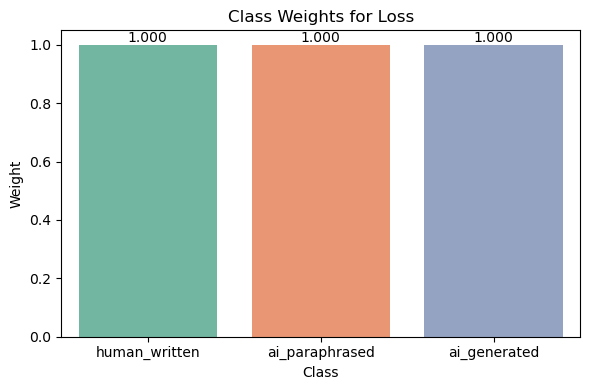

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Visualize class breakdown per split as a stacked bar chart
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

# build count table
split_counts = pd.DataFrame({
    'train': train_df['label'].value_counts(normalize=True),
    'val':   val_df  ['label'].value_counts(normalize=True),
    'test':  test_df ['label'].value_counts(normalize=True),
})

# transpose so splits are on the x‐axis
split_counts = split_counts.T

# choose a simple color palette (you can tweak hex codes as you like)
colors = ['#4c72b0', '#dd8452', '#55a868']

fig, ax = plt.subplots(figsize=(6,4))
split_counts.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=ax
)

ax.set_title("Class Proportion by Split")
ax.set_xlabel("Dataset Split")
ax.set_ylabel("Proportion of samples")
ax.legend(title="Class", loc="upper right", bbox_to_anchor=(1.3, 1))

# annotate percentages on each bar segment
for i, split in enumerate(split_counts.index):
    cum = 0
    for j, cls in enumerate(split_counts.columns):
        val = split_counts.loc[split, cls]
        ax.text(
            i,                              # x position (bar)
            cum + val / 2,                  # y position (middle of segment)
            f"{val:.0%}",                   # label, e.g. “33%”
            ha='center', va='center',
            color='white' if val > 0.1 else 'black',
            fontsize= nine
        )
        cum += val

fig.tight_layout()
plt.show()
# optionally save:
# fig.savefig(config['paths']['figures_dir'] + "split_class_proportions.png", dpi=150)
